In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
!pip3 install pandas numpy opencv-python matplotlib scipy requests openpyxl


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\Hp 15\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
import cv2
import numpy as np

# Load the video
video_path = '100_waheeda_1.mp4'
cap = cv2.VideoCapture(video_path)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Determine block size for 10x10 grid
block_width = width // 10
block_height = height // 10

# Initialize a list to hold the average red values for each block
avg_red_values = np.zeros((10, 10, frame_count), dtype=float)

current_frame = 0

while cap.isOpened() and current_frame < frame_count:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB (if not already in RGB format)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process each block
    for i in range(10):
        for j in range(10):
            # Define the current block
            block = frame_rgb[i*block_height:(i+1)*block_height, j*block_width:(j+1)*block_width]

            # Calculate the average red value for the block
            avg_red = np.mean(block[:, :, 0])  # 0 index for the red channel
            avg_red_values[i, j, current_frame] = avg_red

    current_frame += 1

# Close video file
cap.release()

# Selecting frames 51 to 550 due to noise at the start and end of the video
selected_frames = avg_red_values[:, :, 26:276]
selected_frames


array([[[253.60382909, 253.60990548, 253.60908565, ..., 253.63589892,
         253.63392168, 253.64742477],
        [253.35619213, 253.35619213, 253.34153164, ..., 253.61911651,
         253.60966435, 253.68185764],
        [253.48302469, 253.48302469, 253.46412037, ..., 254.08805941,
         254.06621335, 254.13855131],
        ...,
        [253.69376929, 253.69521605, 253.70780285, ..., 253.93475116,
         253.9220679 , 253.97284915],
        [253.43364198, 253.43364198, 253.43364198, ..., 251.09919946,
         251.10908565, 251.36839313],
        [253.12162423, 253.0226659 , 252.83887924, ..., 246.28641011,
         246.28645833, 246.37369792]],

       [[253.59534144, 253.58945795, 253.57826968, ..., 253.73635224,
         253.71966628, 253.7297936 ],
        [253.48490548, 253.48490548, 253.47299383, ..., 254.13083526,
         254.11115934, 254.14737654],
        [254.17824074, 254.1804591 , 254.13425926, ..., 253.82262731,
         253.82204861, 253.82122878],
        ...,


In [12]:
frame_count

300

In [13]:
avg_red_values.shape

(10, 10, 300)

In [14]:
selected_frames.shape

(10, 10, 250)

In [15]:
# avg_red_values

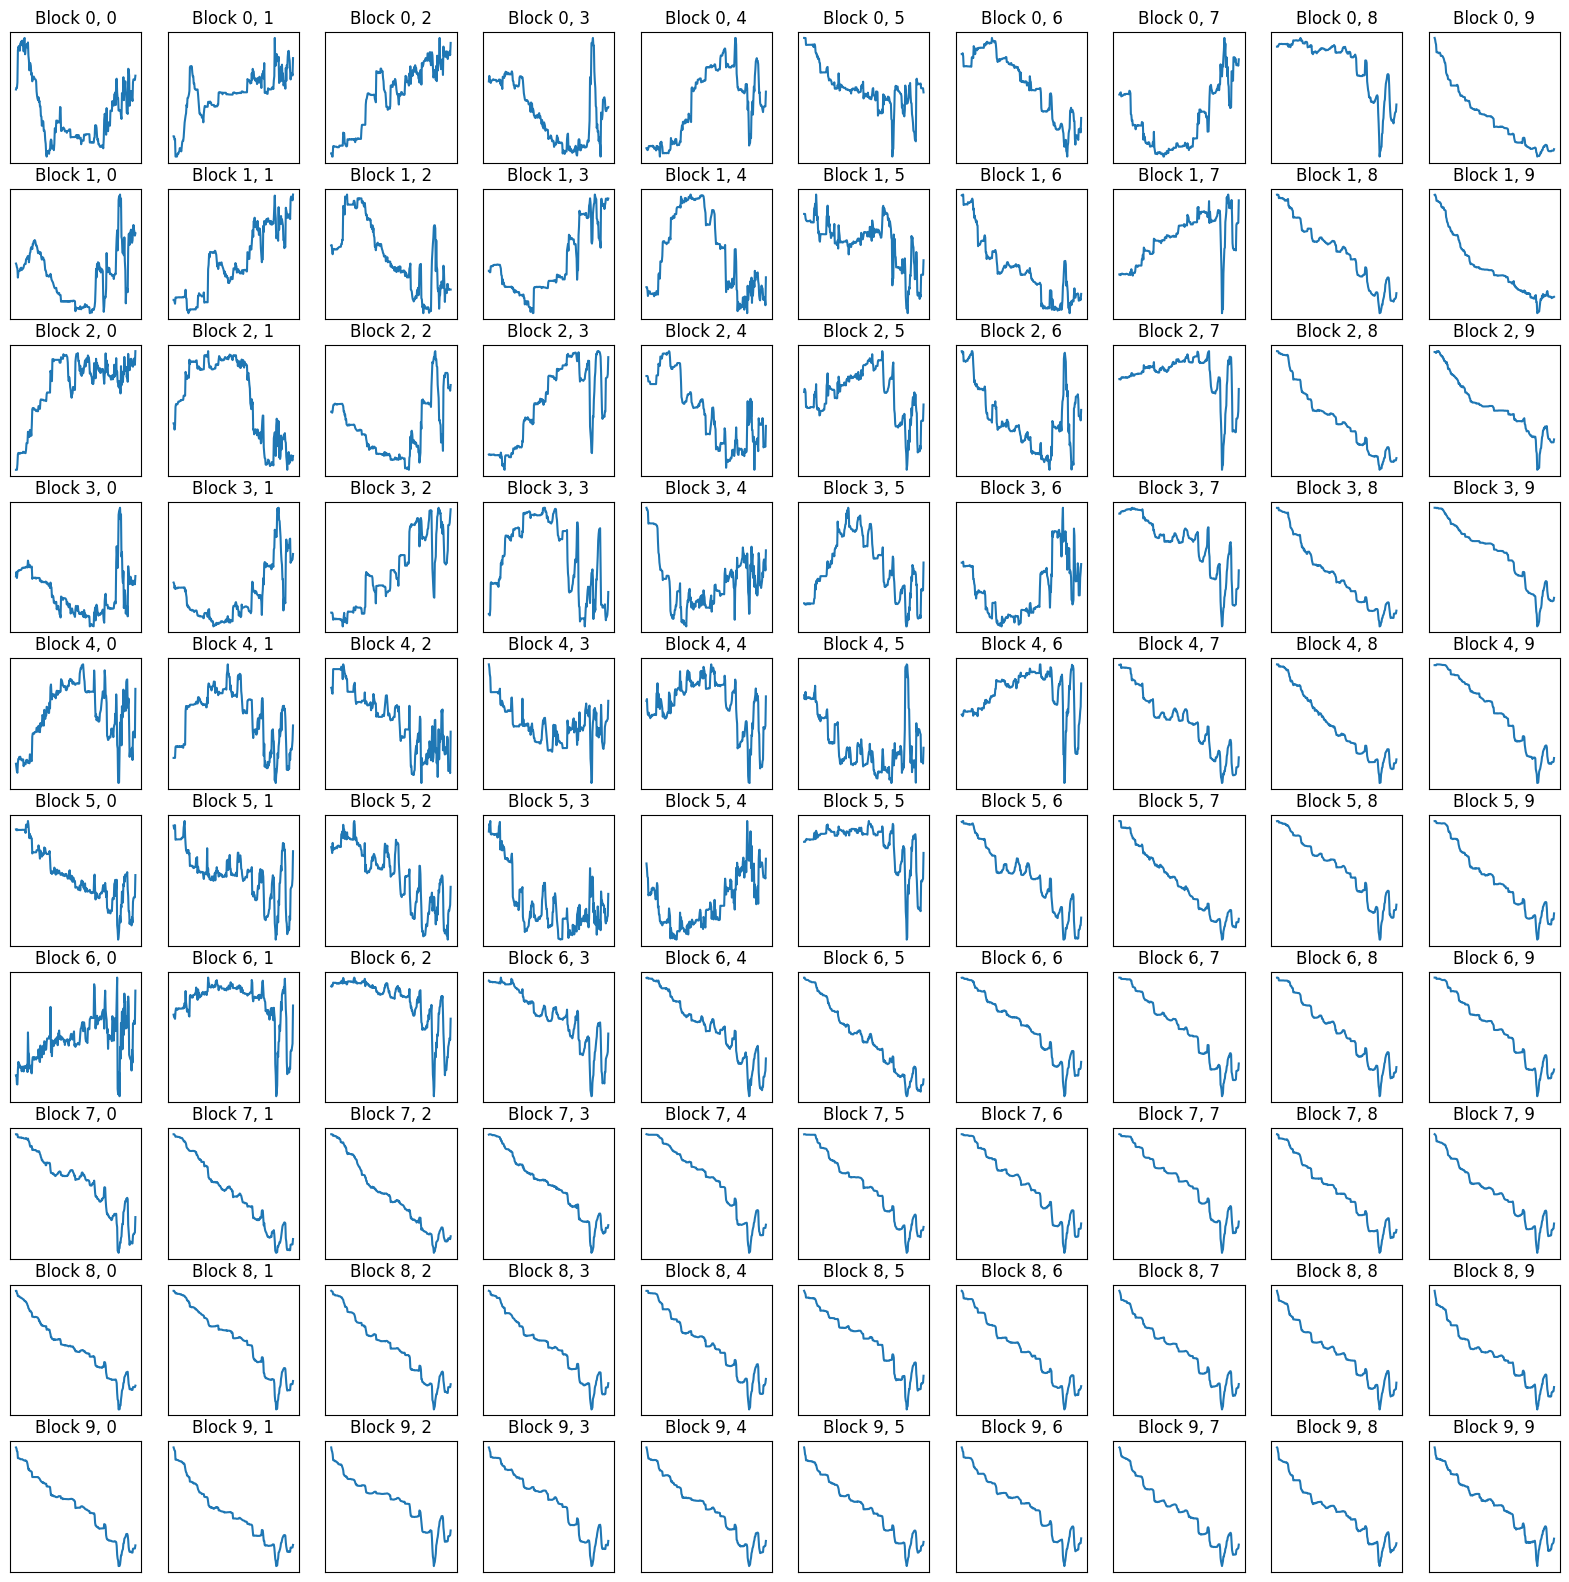

In [16]:
#Plot line graph for each block
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axs[i, j].plot(selected_frames[i, j, :])
        axs[i, j].set_title(f'Block {i}, {j}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.show()



In [17]:
from scipy.signal import butter, filtfilt
from scipy import fftpack

import numpy as np

# Sampling rate (r) and duration of the signal need to be defined based on your video analysis
r = fps  # frames per second from video metadata
duration = frame_count / r  # Duration of the video in seconds

# Generate a Butterworth filter
lowcut = 0.5  # Low frequency threshold (Hz)
highcut = 5.0  # High frequency threshold (Hz)
nyquist = 0.5 * r
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(3, [low, high], btype='band')

# Apply Butterworth filter (assuming 'signal' is your PPG signal extracted from the video)
filtered_signal = filtfilt(b, a, selected_frames)

# Apply FFT and remove frequencies outside the desired range
W = fftpack.fft(filtered_signal)
frequencies = fftpack.fftfreq(len(filtered_signal), 1/r)

# Zero out frequencies outside the desired range
W[(frequencies < lowcut) | (frequencies > highcut)] = 0

# Get the filtered signal back
clean_signal = fftpack.ifft(W)

# Normalize and invert the signal to match hemoglobin level relationship
Sc = np.abs(clean_signal)  # Taking absolute value to handle complex result from ifft
SPG = Sc * -1  # Inverting the signal

# SPG is now your processed PPG signal ready for further analysis
SPG

array([[[-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        ...,
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.00500069, -0.00336349, -0.01422208, ..., -0.06715126,
         -0.05649714, -0.04774476],
        [-0.00750363, -0.01674311, -0.02080776, ..., -0.04048312,
         -0.03177035, -0.02788076],
        [-0.01680449, -0.00678537, -0.02548287, ..., -0.00227259,
         -0.00441879, -0.01139365],
        ...,
        [-0.00666449, -0.00379993, -0.00326979, ..., -

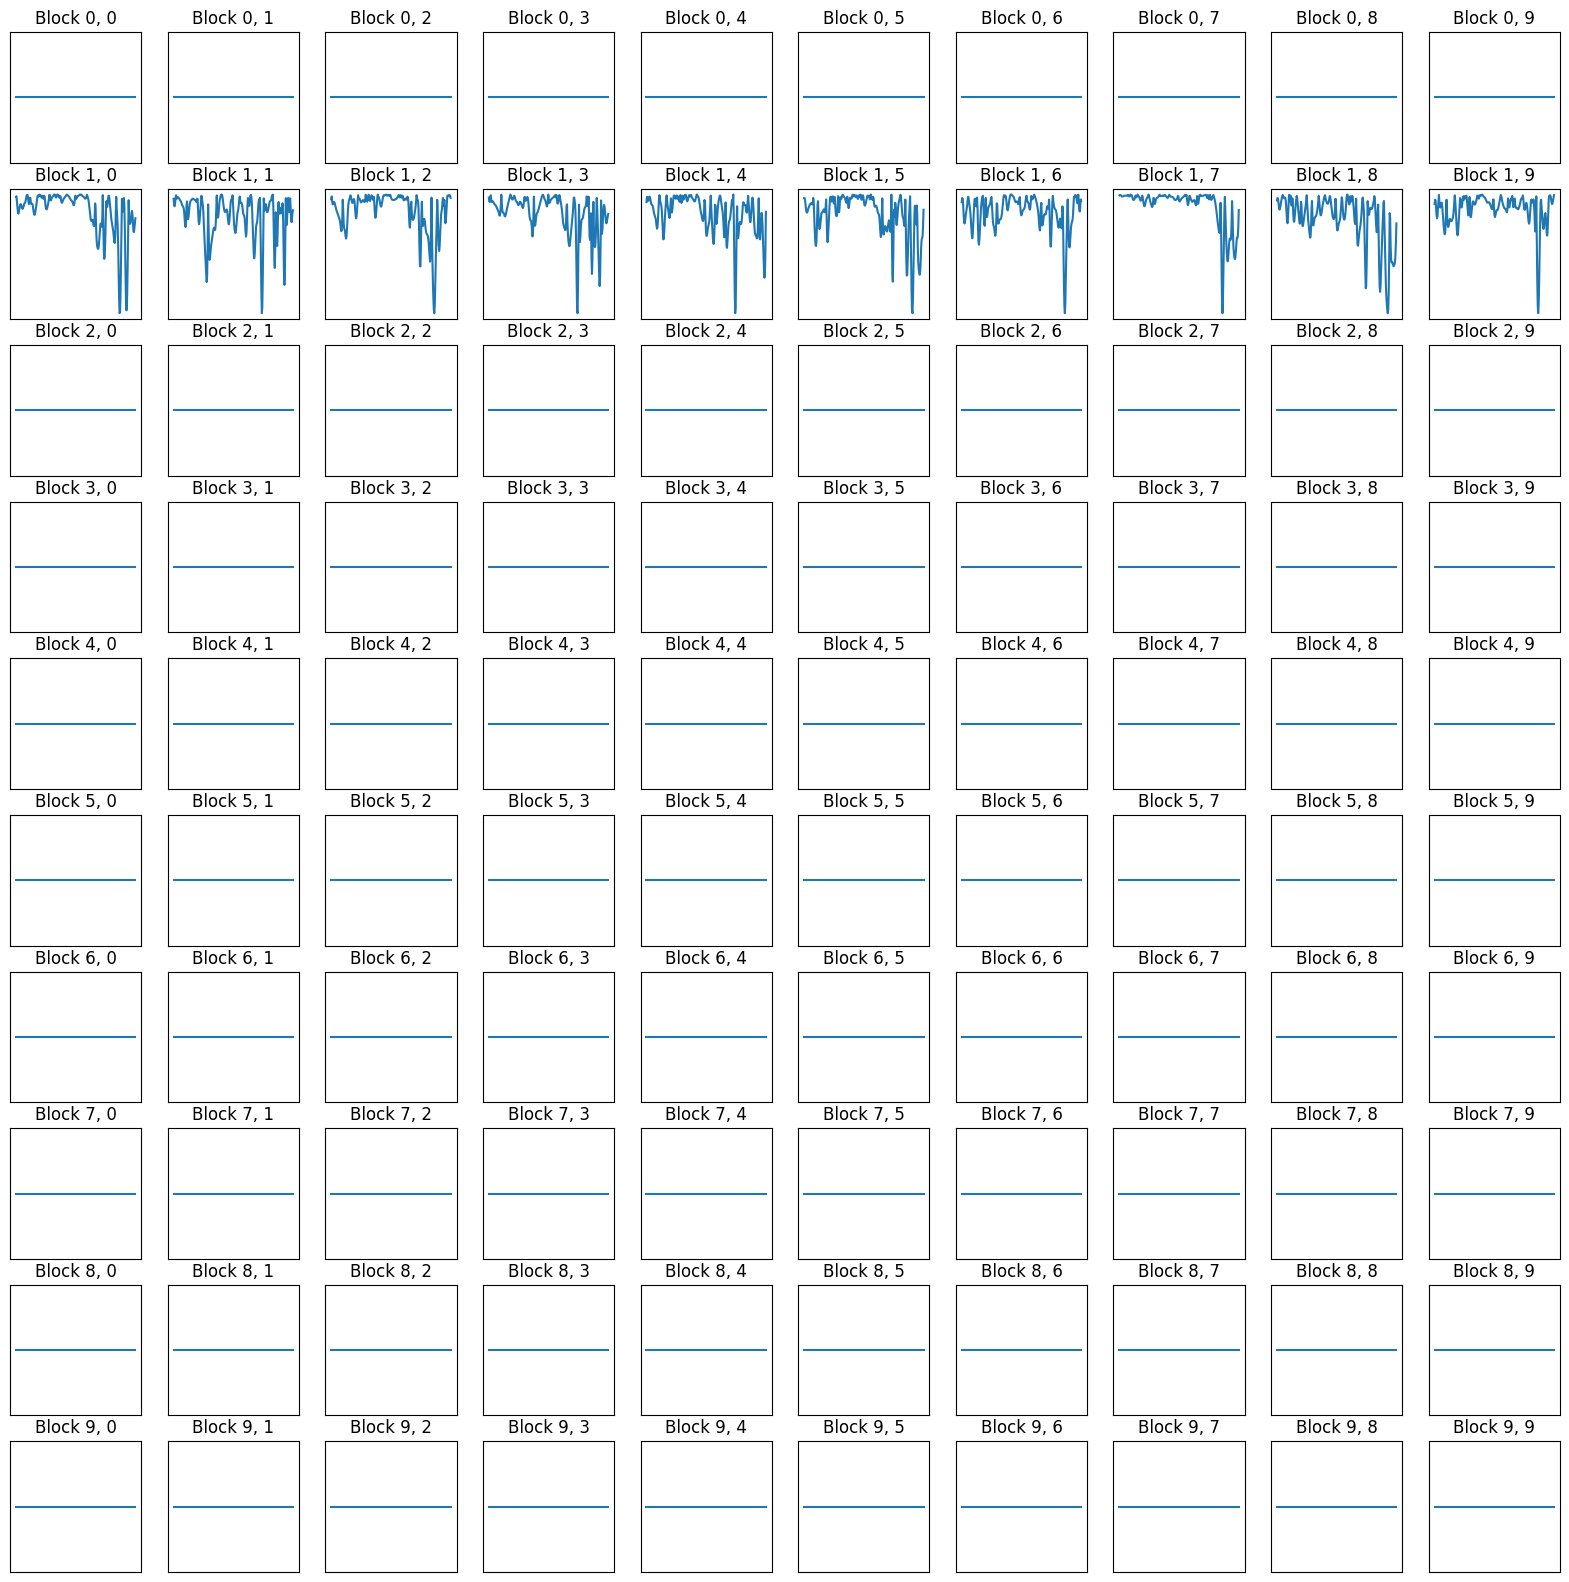

In [18]:
#Plot line graph for each block
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axs[i, j].plot(SPG[i, j, :])
        axs[i, j].set_title(f'Block {i}, {j}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.show()



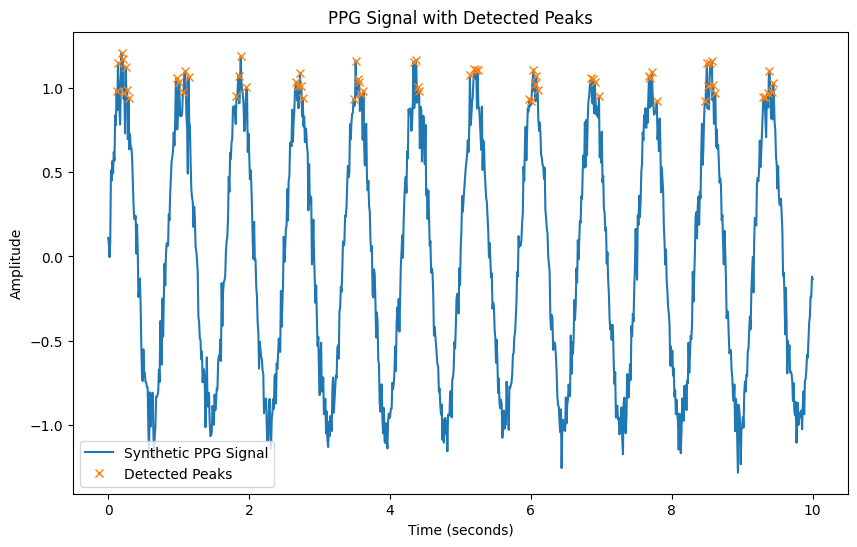

In [19]:
# detecting ppg cycle
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Assuming 'selected_frames' is an array with the pre-processed PPG signal data
# For demonstration, let's create a synthetic PPG signal to represent 'selected_frames'
# Note: In practice, replace this with your actual pre-processed PPG signal data

# Generate a synthetic PPG signal
t = np.linspace(0, 10, 1000)
signal = np.sin(2 * np.pi * 1.2 * t) + np.random.normal(0, 0.1, t.shape)

# Detect peaks which might correspond to systolic peaks in the PPG signal
peaks, _ = find_peaks(signal, height=0.9)  # height threshold might need adjustment based on signal characteristics

# Plot original signal and detected peaks
plt.figure(figsize=(10, 6))
plt.plot(t, signal, label='Synthetic PPG Signal')
plt.plot(t[peaks], signal[peaks], "x", label='Detected Peaks')
plt.title('PPG Signal with Detected Peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# For cycle detection, we proceed by defining the criteria based on the detected peaks
# Note: This step requires further information about the signal characteristics to accurately implement cycle detection
# and is not fully demonstrated here due to the synthetic nature of the data

# Placeholder for PPG cycle detection logic
# This would involve analyzing the intervals between detected peaks, identifying systolic and diastolic peaks,
# and potentially applying additional criteria for accurate cycle identification

# Placeholder for PPG cycle detection output
# Implement logic based on paper's methodology for accurate cycle detection in your actual signal data


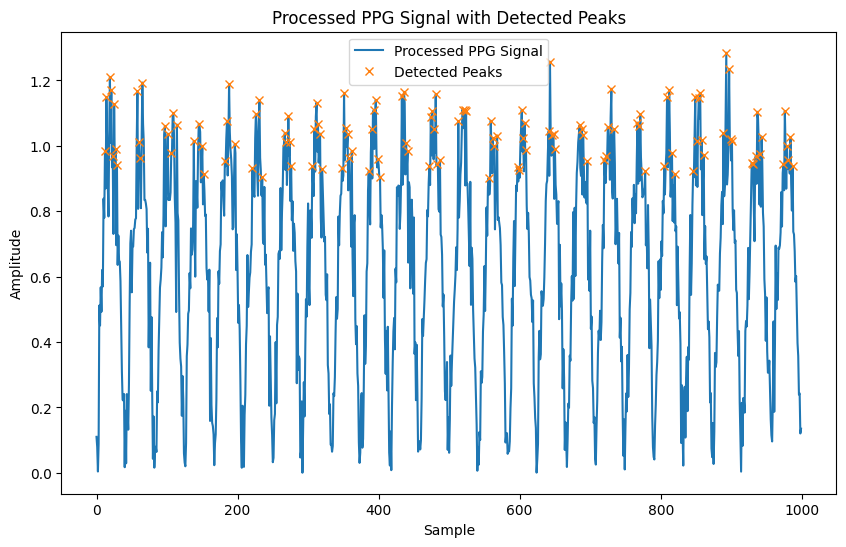

In [20]:
from scipy.signal import find_peaks

# Assuming 'SPG' is the pre-processed PPG signal data
# For demonstration, let's use the synthetic signal created earlier as 'SPG'
SPG = np.abs(np.fft.ifft(np.fft.fft(signal)))

# Detect peaks which might correspond to systolic peaks in the PPG signal
peaks, _ = find_peaks(SPG, height=0.9)  # Adjust height threshold based on signal characteristics

# Since we don't have the actual SPG from the user, this demonstration assumes a synthetic signal.
# The cycle detection logic, as described, would need actual SPG data to implement precisely.

# For demonstration, we're showing peaks detection only.
# The full implementation would further involve identifying minima (for dicrotic notches and start/end points)
# and validating the height and temporal criteria for cycle detection.

# Plotting for visualization
plt.figure(figsize=(10, 6))
plt.plot(SPG, label='Processed PPG Signal')
plt.plot(peaks, SPG[peaks], "x", label='Detected Peaks')
plt.title('Processed PPG Signal with Detected Peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [21]:
# Since we only demonstrated peak detection without specifically identifying PPG cycles,
# let's simulate detected cycles based on the peak detection we performed earlier.

# Simulate detected cycles using the peaks detected in the synthetic signal
# Each cycle is represented by a peak (for simplicity in this demonstration)
detected_cycles_simulated = [
    {'systolic_peak_height': signal[peak], 'cycle_data': f'Cycle {i} Data'} for i, peak in enumerate(peaks)
]

# Select the top 3 cycles based on systolic peak height
selected_cycles_simulated = sorted(detected_cycles_simulated, key=lambda x: x['systolic_peak_height'], reverse=True)[:3]

# Merge the selected cycles for demonstration (assuming merging for feature extraction)
merged_cycles_simulated = " ".join([cycle['cycle_data'] for cycle in selected_cycles_simulated])

selected_cycles_simulated, merged_cycles_simulated




([{'systolic_peak_height': 1.210078834175679, 'cycle_data': 'Cycle 2 Data'},
  {'systolic_peak_height': 1.187778071599498, 'cycle_data': 'Cycle 23 Data'},
  {'systolic_peak_height': 1.1714917367663678, 'cycle_data': 'Cycle 3 Data'}],
 'Cycle 2 Data Cycle 23 Data Cycle 3 Data')

In [22]:
# number of cycles
# Number of detected cycles in the synthetic signal
num_detected_cycles = len(peaks)

num_detected_cycles


125

In [23]:
# Assuming the detected_cycles_simulated list contains the cycle data with systolic peak heights,
# let's dynamically select and merge the cycles for feature extraction.

# Detected cycles simulated from a previous step
detected_cycles_simulated = [
    {'systolic_peak_height': signal[peak], 'cycle_data': np.random.randn(100)}  # Using random data for cycle_data
    for i, peak in enumerate(peaks)
]

# Sorting cycles based on systolic peak height to select the top 3 cycles
selected_cycles_simulated = sorted(detected_cycles_simulated, key=lambda x: x['systolic_peak_height'], reverse=True)[:3]

# Merging the signal data of the selected cycles
merged_signal_data = np.concatenate([cycle['cycle_data'] for cycle in selected_cycles_simulated])

# Feature extraction from the merged signal could include various statistical and signal processing metrics.
# Here we'll extract simple features as an example: mean, standard deviation, and maximum value of the merged signal.
features = {
    'mean': np.mean(merged_signal_data),
    'std_dev': np.std(merged_signal_data),
    'max_value': np.max(merged_signal_data)
}

# Outputting the extracted features
features


{'mean': 0.031036067059515643,
 'std_dev': 1.019685696334251,
 'max_value': 3.462290626653942}

In [24]:
# import numpy as np
# from sklearn.svm import SVR
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import mean_squared_error

# # Simulated feature extraction from merged PPG cycles
# def extract_features(merged_signal):
#     # Placeholder for real feature extraction logic
#     return np.random.rand(45)  # Simulating 45 features

# # Simulate merged PPG signal
# merged_signal = np.random.rand(100)  # Placeholder for the merged signal from selected cycles

# # Extract features from the simulated merged signal
# features = extract_features(merged_signal)

# # Creating a synthetic dataset for demonstration
# X = np.random.rand(100, 45)  # 100 samples, 45 features each
# y = np.dot(X, np.random.rand(45)) + np.random.randn(100) * 0.1  # Synthetic target variable

# # Splitting dataset into training and testing set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Model generation with SVR
# parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10]}
# svr = SVR()
# model = GridSearchCV(svr, parameters)
# model.fit(X_train, y_train)

# # Predicting on the test set
# y_pred = model.predict(X_test)

# # Evaluating the model
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')


In [25]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Step 1: Simulate detected cycles (as done previously)
detected_cycles_simulated = [{'systolic_peak_height': np.random.rand(), 'cycle_data': np.random.randn(100)} for _ in range(100)]
selected_cycles_simulated = sorted(detected_cycles_simulated, key=lambda x: x['systolic_peak_height'], reverse=True)[:3]

print("Detected cycles: ","\n" ,detected_cycles_simulated)
print("\n")
print("Selected cycles: ","\n", selected_cycles_simulated)


Detected cycles:  
 [{'systolic_peak_height': 0.5376150171769479, 'cycle_data': array([-4.63927386e-02, -2.60181837e-01, -5.50943192e-01, -5.13742891e-02,
       -2.31118503e-01,  1.16299706e+00,  4.53761422e-02,  6.79730069e-01,
       -1.26192223e+00,  2.25055254e+00, -2.33641772e+00, -4.54710118e-01,
        1.60747485e+00,  5.73700833e-01, -1.18936926e+00, -8.30607698e-01,
       -1.99678854e-01,  4.40622354e-01, -3.95444136e-01,  6.45139674e-01,
        7.95098768e-01, -1.45817265e+00,  1.49950453e+00,  3.08365189e-01,
       -1.36549980e+00,  2.53860735e-01,  4.52428735e-01, -1.47377377e+00,
        8.69256539e-01, -7.51317207e-01,  1.54584791e+00,  6.88812939e-01,
        1.63721137e+00,  9.91393001e-01, -1.30781364e+00,  2.90477434e-01,
       -8.75019216e-04, -5.74728285e-02,  5.32061532e-01,  6.82354355e-01,
        2.01453986e-01, -3.31935191e-01,  8.65452350e-01,  2.93094444e-01,
       -1.44337692e+00,  5.61872288e-01, -3.72248691e-01,  5.01946858e-01,
       -2.04196285e-

In [36]:
#count of selected cycles
# Number of selected cycles
num_selected_cycles = len(selected_cycles_simulated)
num_selected_cycles




3

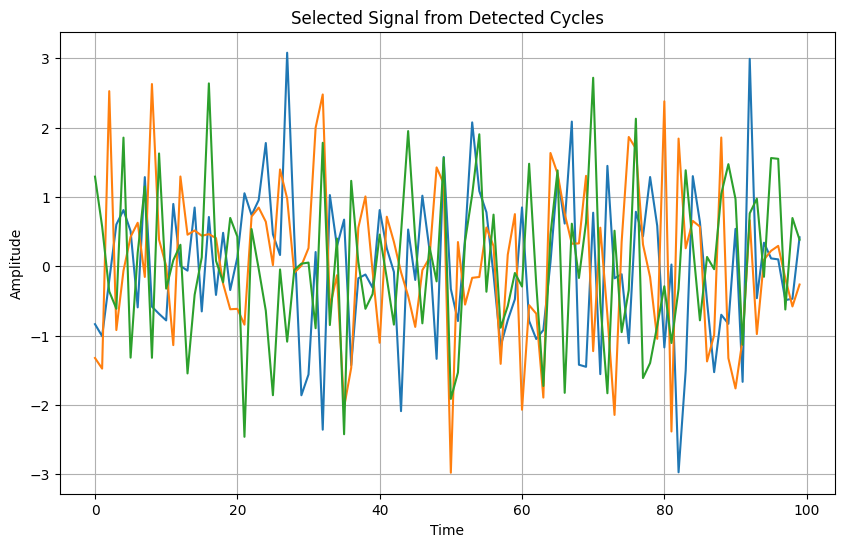

In [26]:
import matplotlib.pyplot as plt

# Extract cycle data from selected cycles
selected_cycle_data = [cycle['cycle_data'] for cycle in selected_cycles_simulated]

# Plot each selected cycle
plt.figure(figsize=(10, 6))
for cycle_data in selected_cycle_data:
    plt.plot(cycle_data)

plt.title('Selected Signal from Detected Cycles')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [27]:
# Step 2: Merge the selected cycles
merged_signal_data = np.concatenate([cycle['cycle_data'] for cycle in selected_cycles_simulated])
merged_signal_data


array([-0.83471222, -1.00816972, -0.20355463,  0.60277191,  0.81110335,
        0.50713247, -0.59246799,  1.28616469, -0.58210602, -0.68611672,
       -0.78057442,  0.89904438,  0.00485108, -0.06273668,  0.84754791,
       -0.65067162,  0.71125216, -0.41296871,  0.48275475, -0.34285376,
        0.12637713,  1.05340985,  0.73789845,  0.95465571,  1.77799336,
        0.46082563,  0.16255498,  3.0802401 ,  0.45013992, -1.86044225,
       -1.56044695,  0.20565059, -2.35673825,  1.02725196,  0.28949239,
        0.67295332, -1.42729175, -0.17354159, -0.11876155, -0.3080509 ,
        0.81088345,  0.25794689, -0.08087045, -2.08921338,  0.53034962,
       -0.19689715,  1.01824978,  0.24038242, -1.33492317,  1.57603451,
       -0.3267758 , -0.7893908 ,  0.40209528,  2.07538895,  1.08565755,
        0.77943321, -0.12093242, -1.15351082, -0.77694027, -0.47510644,
        0.8489679 , -0.78876781, -1.04910178, -0.91922948,  0.05779065,
        1.30674378,  0.61604222,  2.08690859, -1.4197366 , -1.44

(300,)

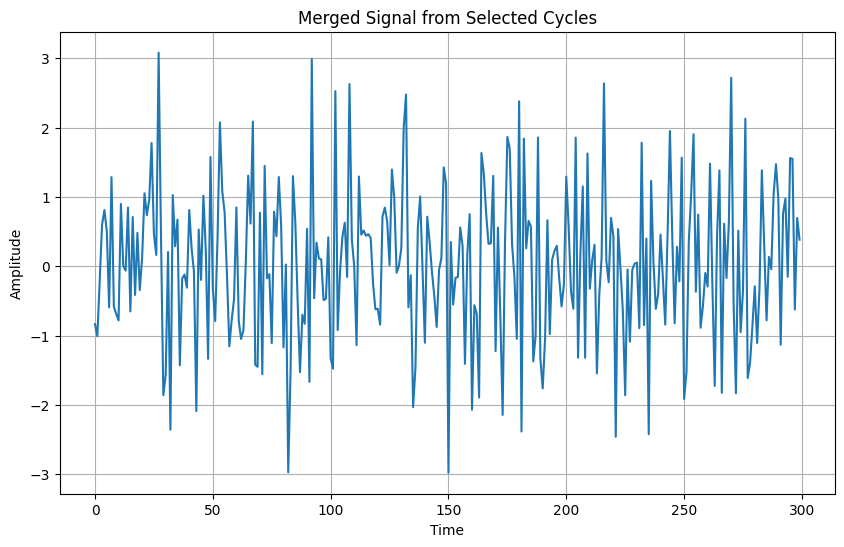

In [30]:
import matplotlib.pyplot as plt

# Plot the merged signal
plt.figure(figsize=(10, 6))
plt.plot(merged_signal_data)

plt.title('Merged Signal from Selected Cycles')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [28]:
# Step 3: Extract features from the merged signal (simulated 45 features)
features = np.random.rand(45)  # Placeholder for real feature extraction logic

# Creating a synthetic dataset for demonstration (assume multiple merged signals)
X = np.random.rand(100, 45)  # 100 samples, 45 features each
y = np.dot(X, np.random.rand(45)) + np.random.randn(100) * 0.1  # Synthetic target variable

# Splitting dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

features



array([0.4649584 , 0.4990203 , 0.12865845, 0.53832035, 0.49036401,
       0.25422252, 0.26356542, 0.18950384, 0.86388134, 0.75997149,
       0.38926597, 0.03591402, 0.90084321, 0.44672434, 0.93070513,
       0.62977552, 0.58864467, 0.53421053, 0.78200855, 0.86805191,
       0.75425816, 0.75835497, 0.16510139, 0.95312898, 0.22068086,
       0.67344877, 0.94299669, 0.31958389, 0.51199036, 0.47663992,
       0.42166144, 0.89595666, 0.88142289, 0.89423127, 0.16361059,
       0.40771421, 0.76521209, 0.83252023, 0.71804327, 0.46673495,
       0.28803464, 0.72585434, 0.88382592, 0.09847574, 0.55984456])

In [29]:
# Step 4: Model generation with SVR
parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10]}
svr = SVR()
model = GridSearchCV(svr, parameters)
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.03200557781189514
